In [2]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import cv2
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from tqdm import trange
from tqdm.auto import tqdm

from IPython.display import clear_output

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


#### Создание класса для извлечения данных из csv файла с метками классов и папки с изображениями в один общий тензор:

* Для избежания переобучения использую аугментацию: случайный поворот на $\pm10^{\circ}$ - transforms.RandomRotation(10) и отражение -transforms.RandomHorizontalFlip(). Использование аугментации привело к повышению качества.
* Все изображения приводятся к размеру 128x128
* И нормализуются.

In [3]:
class MyDataset(Dataset):
    
    def __init__(self, images_path, labels_path):
        self.df = pd.read_csv(labels_path)
        self.labels = self.df[self.df.image != '39401.jpg'].reset_index(drop=True)
        self.class_to_idx = {label: idx for idx, label in enumerate(sorted(self.labels.label.unique()))}
        self.images_path = images_path
        
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        image = Image.open(self.images_path + '/' + self.labels.image[index])
        image = transforms.Compose([transforms.RandomHorizontalFlip(),
                           transforms.RandomRotation(10),
                           transforms.Resize((128, 128)),
                           transforms.ToTensor(), 
                           transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])(image)
        label = torch.tensor(self.class_to_idx[self.labels.label[index]], dtype=torch.long)
        return image, label

In [4]:
dataset = MyDataset('../train', '../train_labels.csv')

#### Разделение на train и test выборку:

In [5]:
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size

In [6]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [8]:
pd.read_csv('../train_labels.csv').label.nunique()

20

Пример входных данных после всех трансформаций:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


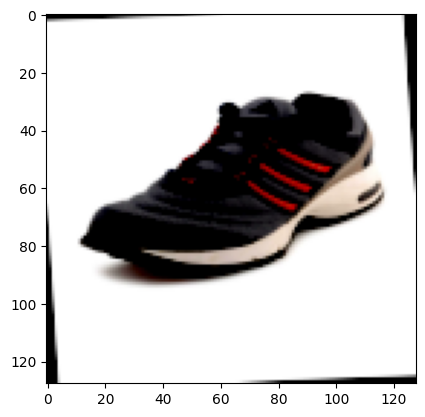

In [9]:
im = dataset.__getitem__(13713)[0]
plt.imshow(im.permute(1, 2, 0))

#### Архитектура модели:
1) Четыре блока, состоящие из сверточного слоя, нормализации по батчу, активации ReLU(), и макс-пулинга.
2) Приведение к вектору.
3) Два линейных слоя, после первого Dropout и активация ReLU.

В первом варианте использовались nn.BatchNorm2d после каждой свертки, но так модель обучалась хуже (судя по графику изменения loss), поэтому, чтобы избежать излешней регуляризации, был оставлен один слой nn.BatchNorm2d(32).

In [25]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.cnn2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.cnn3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.cnn4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(256)
        self.max_pool = nn.MaxPool2d(2, 2)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 20)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.max_pool(F.relu(self.bn1(self.cnn1(x))))
        x = self.max_pool(F.relu(self.cnn2(x)))
        x = self.max_pool(F.relu(self.cnn3(x)))
        x = self.max_pool(F.relu(self.cnn4(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def load_model(self, path="model.pth"):
        model_path = path
        self.load_state_dict(torch.load(model_path, weights_only=True))
    
    def save_model(self, path="model.pth"):
        model_path = path
        torch.save(self.state_dict(), model_path)
        

#### Второй вариант модели:

Здесь для уменьшения размерности используются не pool после каждого слоя свертки и нормализации, а в самой свертке stride=2. Также отличаются числа каналов, а в конце на один линейный слой больше. Такая модель показала самое высокое качество на kaggle равное 0.85571. Самый лучший результат первой модели 0.89933.

Преполагаю, что в первой модели благодаря большему числу каналов извлекается больше признаков, поэтому при использовании первой модели удалось достигнуть более высокую точность.

In [24]:
class Model2(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.cnn2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(12)
        self.cnn3 = nn.Conv2d(in_channels=12, out_channels=24, kernel_size=3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(24)
        self.cnn4 = nn.Conv2d(in_channels=24, out_channels=48, kernel_size=3, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(48)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8 * 8 * 48, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 20)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.bn1(self.cnn1(x)))
        x = F.relu(self.bn2(self.cnn2(x)))
        x = F.relu(self.bn3(self.cnn3(x)))
        x = self.pool(F.relu(self.bn4(self.cnn4(x))))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

    def load_model(self, path="model.pth"):
        model_path = path
        self.load_state_dict(torch.load(model_path, weights_only=True))

    def save_model(self, path="model.pth"):
        model_path = path
        torch.save(self.state_dict(), model_path)

In [12]:
interval = 100
train_ts, train_loss = [], []
val_ts, val_loss, val_acc = [], [], []

In [13]:
def show_progress(t):
    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(20, 5))
    fig.suptitle(f'Epoch {t:3.3f}', fontsize=16)
    ax1.set_title('loss')
    ax1.set_xlabel('time (epochs)')
    ax1.set_ylabel('loss')
    ax1.plot(train_ts, train_loss, c='darkblue', lw=3, label='train')
    ax1.plot(val_ts, val_loss, c='green', marker='o', lw=5, label='val')
    ax1.legend()
    ax2.set_title('accuracy')
    ax2.set_xlabel('time (epochs)')
    ax2.plot(val_ts, val_acc, c='green', marker='o', lw=5, label='val')
    ax2.legend()
    plt.show()

In [14]:
def train(epoch, dataloader, model, loss_fn, optimizer):
    model.train()
    num_batches = len(dataloader)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        pred = model.forward(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % interval == 0:
            t = epoch + (batch + 1)/num_batches
            train_ts.append(t)
            train_loss.append(loss.item())
            show_progress(t)

In [15]:
def test(epoch, dataloader, model, loss_fn):
    model.eval()
    num_batches = len(dataloader)
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    val_ts.append(epoch+1)
    val_loss.append(test_loss)
    val_acc.append(correct)
    show_progress(epoch+1)

In [16]:
model = Model().to(device)

In [17]:
loss_fn = F.cross_entropy
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

Процесс обучения первой модели:

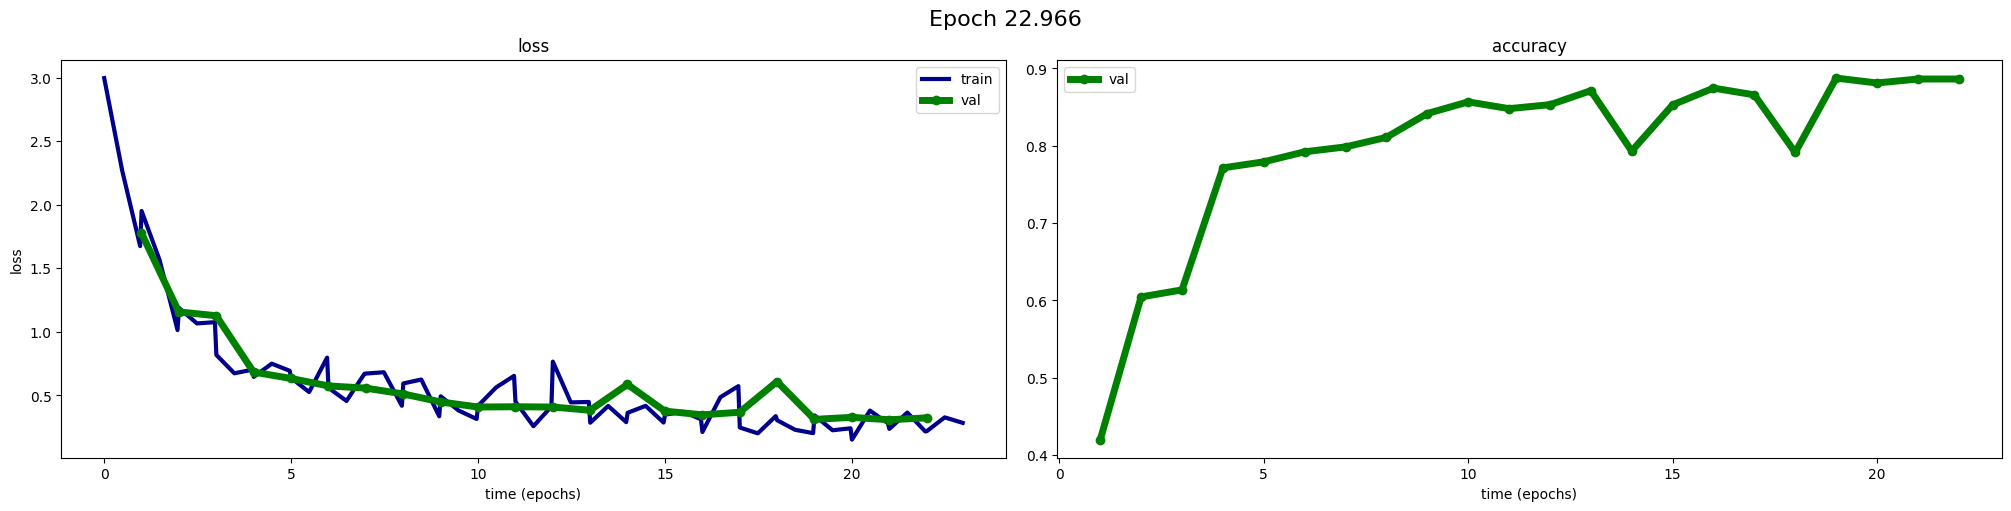

In [ ]:
epochs = 50
for t in trange(epochs):
    train(t, trainloader, model, loss_fn, optimizer)
    test(t, testloader, model, loss_fn)
    if t % 5 == 0:
        model.save_model(path=f'/kaggle/working/model_{t}.pth')

In [70]:
model.save_model(path='/kaggle/working/model.pth')

In [18]:
#model1 = Model()
#model1.load_model(path='/kaggle/working/' + 'model_10.ph')

Класс для получения предсказанных меток:

In [222]:
def pred(dataloader, model):
    model.eval()
    size = len(dataloader.dataset)
    with torch.no_grad():
        for X in dataloader:
            X = X.to(device)
            pred = model.forward(X)
    return F.softmax(pred)

Класс для создания тензора с данными для которых нужно сделать предсказания:

In [19]:
class MyTestDataset(Dataset):
    def __init__(self, images_path, transform=None):
        self.images_path = images_path
        self.image_files = sorted(os.listdir(images_path))
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        image_path = os.path.join(self.images_path, self.image_files[index])
        image = Image.open(image_path)
        image = image.resize((128, 128), Image.Resampling.LANCZOS)
        image = transforms.Compose([transforms.ToTensor()])(image)
        return image, self.image_files[index]

После 85 эпохи началось переобучение, начал колебаться и падать лосс на валидационной выборке.

In [ ]:
epochs = 101
for t in trange(80, epochs):
    train(t, trainloader, model, loss_fn, optimizer)
    test(t, testloader, model, loss_fn)
    model.save_model(path=f'/kaggle/working/model_{t}.pth')

<img src="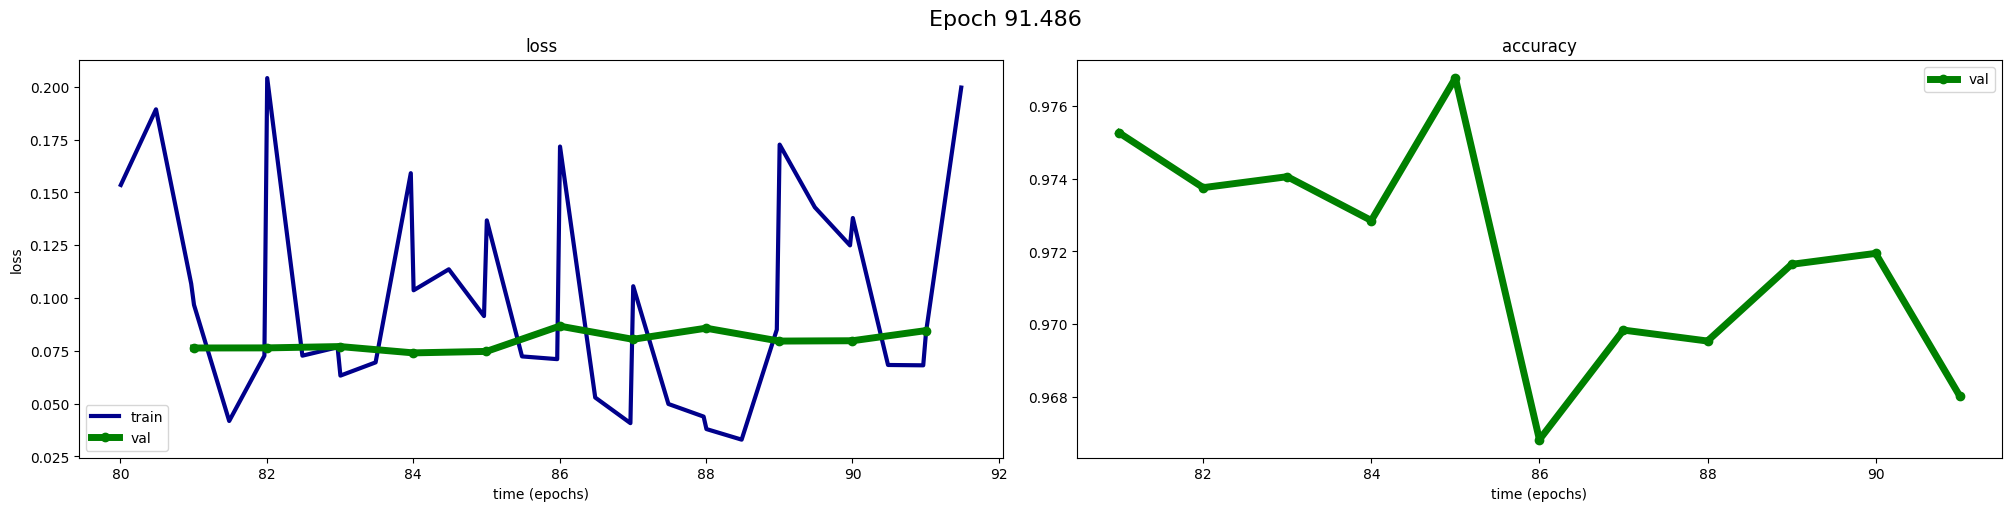
">

In [26]:
model1 = Model().to(device)

In [27]:
model1.load_state_dict(torch.load('model_84.pth', map_location=torch.device('cpu')))

<All keys matched successfully>

In [28]:
test_dataset = MyTestDataset(images_path='../test/test')

test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

model1.eval()

predictions = []
file_names = []

with torch.no_grad():
    for images, names in test_loader:
        outputs = model1(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(predicted.cpu().numpy())
        file_names.extend(names)

Сохранение результата:

In [30]:
idx_to_class = {idx: class_name for class_name, idx in dataset.class_to_idx.items()}

In [31]:
predictions_labels = np.array([idx_to_class[i] for i in predictions])

In [32]:
ans2 = pd.read_csv('../sample_submission.csv')

In [33]:
ans2.label = predictions_labels

In [34]:
ans2.image = np.array(file_names)

In [35]:
ans = pd.read_csv('kaggle4.csv')

In [36]:
ans.iloc[180:190]

,image,label
180,10474.jpg,Shirts
181,10478.jpg,Shirts
182,10480.jpg,Shirts
183,10481.jpg,Shirts
184,10484.jpg,Shirts
185,10485.jpg,Jeans
186,10493.jpg,Tshirts
187,10495.jpg,Kurtas
188,10496.jpg,Tshirts
189,10497.jpg,Tops


In [37]:
ans2.iloc[180:190]

,image,label
180,10474.jpg,Shirts
181,10478.jpg,Shirts
182,10480.jpg,Shirts
183,10481.jpg,Shirts
184,10484.jpg,Shirts
185,10485.jpg,Jeans
186,10493.jpg,Tshirts
187,10495.jpg,Shirts
188,10496.jpg,Tshirts
189,10497.jpg,Tops


In [38]:
pd.concat((ans[ans.label != ans2.label], ans2[ans.label != ans2.label].label), axis=1).iloc[380:410]

,image,label,label
7089,31109.jpg,Tops,Tshirts
7097,31149.jpg,Tshirts,Tops
7105,31162.jpg,Tshirts,Jeans
7115,31209.jpg,Casual Shoes,Sports Shoes
7121,31219.jpg,Sports Shoes,Casual Shoes
7123,31225.jpg,Shirts,Tshirts
7129,31245.jpg,Shirts,Tshirts
7132,31252.jpg,Socks,Tshirts
7167,31327.jpg,Casual Shoes,Formal Shoes
7251,3175.jpg,Casual Shoes,Sports Shoes


In [237]:
ans2.to_csv('kaggle5.csv', index=False)